In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

In [2]:
from utils import extract_page_text_content, launch_chromedriver
from models import HtmlPage, TextContainer, Figure
from pathlib import Path
from PIL import Image

pdf_samples_base = Path('../tests/data/sample_html_page/')
pdf_path = pdf_samples_base / "page4.html"

## Decipher code

In [3]:
import main
import utils

base_test_folder = Path('../tests')
output = base_test_folder / "output"
pdf1_path = base_test_folder / "data" / "pdf-2.pdf"
# xpdf_path  = base_test_folder / "output"



In [4]:
pil_images = main.fetch_pages_as_images(pdf_path=pdf1_path.resolve(), base_folder=output)

In [5]:
xpdf_folder_path = utils.pdf2html(pdf1_path.resolve(), output.resolve(), "pdf2")
# pages = main.get_pages(xpdf_path)

In [6]:
pages = main.get_pages(Path(xpdf_folder_path))

In [7]:
import math

def merge_left_padded_points(sorted_points: list[tuple[int, int]], padding_threshold=10) -> list[tuple[int, int]]:
    """ Update the sorted counts by merging padded text elements """
    left_points = sorted_points.copy()
    i = 0
    while i < len(left_points):
        j = i + 1
        while j < len(left_points):
            if abs(left_points[i][0] - left_points[j][0]) <= padding_threshold:
                left_points[i] = (left_points[i][0], left_points[i][1] + left_points[j][1])
                del left_points[j]
            else:
                j = j + 1
        i = i + 1
    return sorted(left_points, key=lambda x: x[1], reverse=True)

def get_columns_coordinates(sorted_left_points, row_width, page_width):
    # i don't think this is right...
    mode_first_left_point = sorted_left_points[0][1]
    print(mode_first_left_point)
    if float(mode_first_left_point) / len(sorted_left_points) > .75 or float(row_width) / page_width > .5:
        return [sorted_left_points[0][0]]
    else:
        # find starting point for second column
        for i in range(1, len(sorted_left_points)):
            if abs(sorted_left_points[i][0] - sorted_left_points[0][0]) > row_width:
                return [
                    min(sorted_left_points[i][0], sorted_left_points[0][0]),
                    max(sorted_left_points[i][0], sorted_left_points[0][0]),
                ]


def calculate_document_layout(pages: list[HtmlPage], width_threshold=30):
    """ Implements the document layout acquisition procedure from section 2.2 """
    x0s = [y.x0 for x in pages for y in x.text_containers if y.width > width_threshold]
    y0s = [y.y0 for x in pages for y in x.text_containers if y.width > width_threshold]
    x1s = [y.x1 for x in pages for y in x.text_containers if y.width > width_threshold]
    widths = [y.width for x in pages for y in x.text_containers if y.width > width_threshold]
    heights = [y.height for x in pages for y in x.text_containers if y.width > width_threshold]

    # sorting by most occurent value (mode) using tuples (width, count(width))
    sorted_x0s = sorted([(i, x0s.count(i)) for i in set(x0s)], key=lambda x: x[1], reverse=True)
    sorted_widths = sorted([(i, widths.count(i)) for i in set(widths)], key=lambda x: x[1], reverse=True)
    sorted_heights = sorted([(i, heights.count(i)) for i in set(heights)], key=lambda x: x[1], reverse=True)  

    row_height = sorted_heights[0][0]
    row_width = sorted_widths[0][0]

    # consider padding
    sorted_x0s = merge_left_padded_points(sorted_x0s)

    cr_x0 = sorted_x0s[0][0]
    cr_y0 = max(0, min(y0s))
    cr_x1 = max(x1s)
    cand_y1s = [y.y1 for x in pages for y in x.text_containers if y.x0 >= cr_x0 and y.x1 <= cr_x1 and y.y0 >= cr_y0]
    cr_y1 = max(cand_y1s)
    cr = [cr_x0, cr_y0, cr_x1 - cr_x0, cr_y1 - cr_y0]


    # calculate number of columns
    page_width = pages[0].width
    number_cols = math.floor(page_width / row_width)
    
    if number_cols == 1:
        cols_layout = [cr_x0]
    else: # restrict here to 2?
        candidates = [y.x0 for x in pages for y in x.text_containers if y.x0 >= cr_x0 + row_width]        
        cols_layout = [sorted_x0s[0][0], min(candidates)]

    # TODO: fix the columns coordinates... use page width and then search for starting x0
    # cols_layout = get_columns_coordinates(sorted_x0s, row_width, page_width)
    

    return cr, row_width, row_height, cols_layout


In [8]:
content_region, row_width, row_height, cols_layout = calculate_document_layout(pages)
number_cols = len(cols_layout)
content_region, cols_layout


([36, 24, 535, 745], [36, 296])

In [9]:

from typing import Optional

def draw_content_region(ax, content_region: list[int]):
  rect = patches.Rectangle((content_region[0], content_region[1]),
                            content_region[2], content_region[3],
                            linewidth=1,
                            edgecolor='black',
                            facecolor='none',
                            alpha=0.4)
  ax.add_patch(rect)


def draw_text_regions(ax, page: HtmlPage):
  for bbox in page.text_containers:
    rect = patches.Rectangle((bbox.x0, bbox.y0),
                            bbox.width, bbox.height,
                            linewidth=1,
                            edgecolor='blue',
                            facecolor='none',
                            alpha=0.4)
    ax.add_patch(rect)


def draw_figure_candidates(ax, bboxes):
  for bbox in bboxes:
    rect = patches.Rectangle((bbox[0], bbox[1]),
                            bbox[2], bbox[3],
                            linewidth=1,
                            edgecolor='red',
                            facecolor='red',
                            alpha=0.9)
    ax.add_patch(rect)


def draw_bboxes(ax, bboxes, edgecolor: Optional[str], facecolor: Optional[str], alpha: float):
  # bbox: [x0, y0, w, h]
  for bbox in bboxes:
    rect = patches.Rectangle((bbox[0], bbox[1]),
                            bbox[2], bbox[3],
                            linewidth=1,
                            edgecolor=edgecolor if edgecolor else 'null',
                            facecolor=facecolor if facecolor else 'null',
                            alpha=alpha)
    ax.add_patch(rect)

def draw_columns(ax, cols_layout, page_height):
  for col in cols_layout:
    ax.vlines(col, 0, page_height, colors="red", linestyles="dashed")



## Graphical content detection

In [10]:
from os import listdir
import cv2
import numpy as np
import re


def calc_img_scale(image, page_width, page_height):
    # the PNG may be bigger than the html size
    height, width, _ = image.shape
    if height > width:
      return float(height) / page_height
    else:
      return float(width) / page_width

def overlap_ratio_based(box1, box2):
    # overlap ratio based on box1
    box1_x0 = box1[0]
    box1_y0 = box1[1]
    box1_x1 = box1[0] + box1[2]
    box1_y1 = box1[1] + box1[3]

    box2_x0 = box2[0]
    box2_y0 = box2[1]
    box2_x1 = box2[0] + box2[2]
    box2_y1 = box2[1] + box2[3]

    SI = max(0, min(box1_x1, box2_x1) - max(box1_x0, box2_x0)) * max(
        0, min(box1_y1, box2_y1) - max(box1_y0, box2_y0)
    )
    box1_area = box1[2] * box1[3]    
    if box1_area == 0:
        overlap_ratio = 0
    else:
        overlap_ratio = float(SI) / box1_area
    return overlap_ratio

def detect_boxes(pages: list[HtmlPage], xpdf_path: str):    
    page_width = pages[0].width
    page_height = pages[0].height

    images = []

    for page in pages:
      ""
    

In [36]:
def estimate_number_figures(text_containers: list[TextContainer]):
  num_figs = 0
  for box in text_containers:
    rgx = re.search(r"\d+", box.text)
    if rgx is not None:
      num_figs = max(int(rgx.group()), num_figs)
  return num_figs


def filter_content_boxes(page: HtmlPage):
    """ Get containers with text matching Table or Fig """
    table_boxes = []
    figure_boxes = []
    for text_container in page.text_containers:
      text = text_container.text.lower().strip()
      if text.startswith("table") or text.startswith("box"):
        table_boxes.append(text_container)
      elif text.startswith("fig"):
        figure_boxes.append(text_container)
      else:
        text = text[:6].replace(" ", "")
        if text.startswith("fig"): figure_boxes.append(text_container)
    return figure_boxes, table_boxes


def get_potential_figure_bboxes(base_folder_path: str, page: HtmlPage, layout: list[int], row_height: int):
    """ Process the page image to find potential contours that hold figures """

    figure_boxes, table_boxes = filter_content_boxes(page)

    png_path = str((Path(base_folder_path) / page.img_name).resolve())
    page_image = cv2.imread(png_path)
    page_image_gray = cv2.cvtColor(page_image, cv2.COLOR_BGR2GRAY)
    # match PNG and html sizes
    scaling = calc_img_scale(page_image, page.width, page.height)

    _, thresh = cv2.threshold(page_image_gray, 240, 255, cv2.THRESH_BINARY_INV)
    kernel = np.ones((5, 5), np.uint8)
    dilation = cv2.dilate(thresh, kernel, iterations=1)
    contours, _ = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # canvas_with_contours = np.zeros(thresh.shape, dtype=np.uint8)

    potential_fig_bboxes = []
    for cnt in contours:
      cnt_bbox = cv2.boundingRect(cnt)
      scaled_cnt_bbox = [int(float(x) / scaling) for x in cnt_bbox]
      overlap_w_captions = 0
      for caption_box in figure_boxes:
        overlap_w_captions += overlap_ratio_based(caption_box.to_bbox(), scaled_cnt_bbox)
      overlap_w_layout = overlap_ratio_based(layout, scaled_cnt_bbox)
      layout_margin = 10

      box_height = scaled_cnt_bbox[3]
      if overlap_w_captions < 0.5 and overlap_w_layout < 0.2 and scaled_cnt_bbox[1] >= layout[1] - layout_margin and box_height > row_height:
          # cv2.drawContours(canvas_with_contours, [cnt], 0, 255, -1)
          potential_fig_bboxes.append(scaled_cnt_bbox)

    return potential_fig_bboxes, figure_boxes, table_boxes


def manhattan(a, b):
    return sum(abs(a - b) for a, b in zip(a, b))

def bbox_distance(bbox1, bbox2):
    x1 = bbox1[0]
    y1 = bbox1[1]
    x1b = bbox1[0] + bbox1[2]
    y1b = bbox1[1] + bbox1[3]
    x2 = bbox2[0]
    y2 = bbox2[1]
    x2b = bbox2[0] + bbox2[2]
    y2b = bbox2[1] + bbox2[3]
    left = x2b < x1
    right = x1b < x2
    bottom = y2b < y1
    top = y1b < y2
    if top and left:
        return manhattan((x1, y1b), (x2b, y2))
    elif left and bottom:
        return manhattan((x1, y1), (x2b, y2b))
    elif bottom and right:
        return manhattan((x1b, y1), (x2, y2b))
    elif right and top:
        return manhattan((x1b, y1b), (x2, y2))
    elif left:
        return x1 - x2b
    elif right:
        return x2 - x1b
    elif bottom:
        return y1 - y2b
    elif top:
        return y2 - y1b
    else:  # rectangles intersect
        return 0


def remove_tables_from_candidates(table_boxes: list[TextContainer], candidates: list):
    filtered_candidates = []
    for table_textbox in table_boxes:
      # the caption appears over the table
      fake_table_box_top = table_textbox.to_bbox()
      fake_table_box_top[3] = 4 * row_height # make it taller
      # the caption appears below the table
      fake_table_box_bottom = fake_table_box_top
      fake_table_box_bottom[1] = fake_table_box_bottom[1] - 4 * row_height

      for pot_fig_bbox in candidates:
        overlap_top = overlap_ratio_based(pot_fig_bbox, fake_table_box_top)
        overlap_bottom = overlap_ratio_based(pot_fig_bbox, fake_table_box_bottom)
        if overlap_top <= 0.1 and overlap_bottom <= 0.1:
          filtered_candidates.append(pot_fig_bbox)
    return filtered_candidates


def is_multicol_caption(box: TextContainer, page_width, row_width, cols_layout):
    ROW_EXTRA = row_width/5
    page_mid = page_width / 2
    # if  box.width > row_width + ROW_EXTRA or (box.x0 < page_mid and box.x1 > page_mid):  
    if box.x1 > cols_layout[1] or box.x0 > cols_layout[1] + ROW_EXTRA:
      return True
    return False


def estimate_caption_regions(caption_boxes: list[TextContainer], num_columns: int, page_width: int, page_height: int, row_width: int, row_height: int, cols_layout: list, layout):
    # sweep the page vertically to find the possible location of the figures
    # on top of the captions
    #TODO the method is good for on top estimations but not for cases with 
    # captions to the side in unusual column alignments
    if len(caption_boxes) == 0: return []

    regions = []
    # if len(caption_boxes) == 1:
    #     return [(caption_boxes[0], layout)]
    
    if num_columns == 1:
      vert_sweep = 1
      sorted_caption_boxes = sorted(caption_boxes, key=lambda x: x[1]) # by y0
      for box in sorted_caption_boxes:
        regions.append([1, 1, page_width - 2, box.y0 - vert_sweep])
        vert_sweep = box.y0 + box.height
    elif num_columns == 2:
      sweep = [layout[1]] * num_columns
      sorted_caption_boxes = sorted(caption_boxes, key=lambda x: (x.y0, x.x0)) # by y0 and x0
      for box in sorted_caption_boxes:
        multicol_caption = is_multicol_caption(box, page_width, row_width, cols_layout)
        if multicol_caption:
          print('multicol')
          region = [layout[0], sweep[0], layout[3], box.y0 - sweep[0]]
          sweep[0] = box.y0 + box.height
        else:
          if box.x0 < cols_layout[1]:
            region = [box.x0, sweep[0], cols_layout[1]-cols_layout[0], box.y0 - sweep[0]]
            sweep[0] = box.y0 + box.height
          else:
            tmp = min(box.x0, cols_layout[0] + row_width + 50)
            region = [tmp, sweep[1], page_width - tmp, box.y0 - sweep[1]]
            sweep[1] = box.y0 + box.height
        regions.append((box, region))
    else:
      print("skipping page: calculations do not support PDFs with more than 2 columns")      
      # raise Exception("Calculations do not support PDFs with more than 2 columns")
    
    return regions


def match_figures_with_captions(regions, candidates)-> list[Figure]:
    """ Match candidate regions for captions to candidate figures per page """
    # change the logic here. Every candidate figure inside the region can be
    # merged and be considered a figure.
    figures = []
    for caption_box, region_bbox in regions:
      print("\t", caption_box.text)
      sparse_figures = [x for x in candidates if overlap_ratio_based(x, region_bbox) > 0.9]
      if len(sparse_figures) > 1:
        x0 = min([x[0] for x in sparse_figures])
        y0 = min([x[1] for x in sparse_figures])
        x1 = max([x[0]+x[2] for x in sparse_figures])
        y1 = max([x[1]+x[3] for x in sparse_figures])
        figure = Figure(x0=x0, y0=y0, width=x1-x0, height=y1-y0, caption=caption_box)
        figures.append(figure)
    return figure

def expand_captions(page: HtmlPage, figures: list[Figure]):
    """ Search in the page for the next sentences to complement the caption """
    


def match_figures_and_captions(caption_boxes: list[TextContainer], table_boxes: list[TextContainer], pot_fig_bboxes: list, page: HtmlPage, row_height: int, fig_threshold = 30):
    
    DISTANCE_FIG_CAPTION = 50    
    filtered_candidates = remove_tables_from_candidates(pot_fig_bboxes)




    




page1.png
page2.png
page3.png
multicol
	 Figure 1, A and B; supplemental material available
page4.png
multicol
multicol
	 Figure 1. CKD mice have defective glucose-stimulated insulin secretion in vivo. (A) Blood glucose and (B) AUC during an IPGTT (1 g/kg) in CKD or
	 Figure 3, A and B). To investigate the contribution of ROS to
page5.png
multicol
	 Figure 2. Isolated islets from CKD mice have reduced
page6.png
multicol
	 Figure 3. CKD mice show an increase of O-GlcNAcylation in islets and oxidative stress markers. (A and B) Immunostaining of 8-OHG in pancreatic sec-
page7.png
multicol
multicol
	 Figure 4. Exposure to urea in drinking water increases circulating urea levels and inhibits insulin secretion. (A) Urea consumption in drinking water
	 Figure 7, C and F). Depolarization-induced exocytosis under basal
page8.png
multicol
	 Figure 5. The insulin secretory defect resulting from exposure of normal mouse or human islets to urea is prevented by antioxidant treatment or GFAT
page9.pn

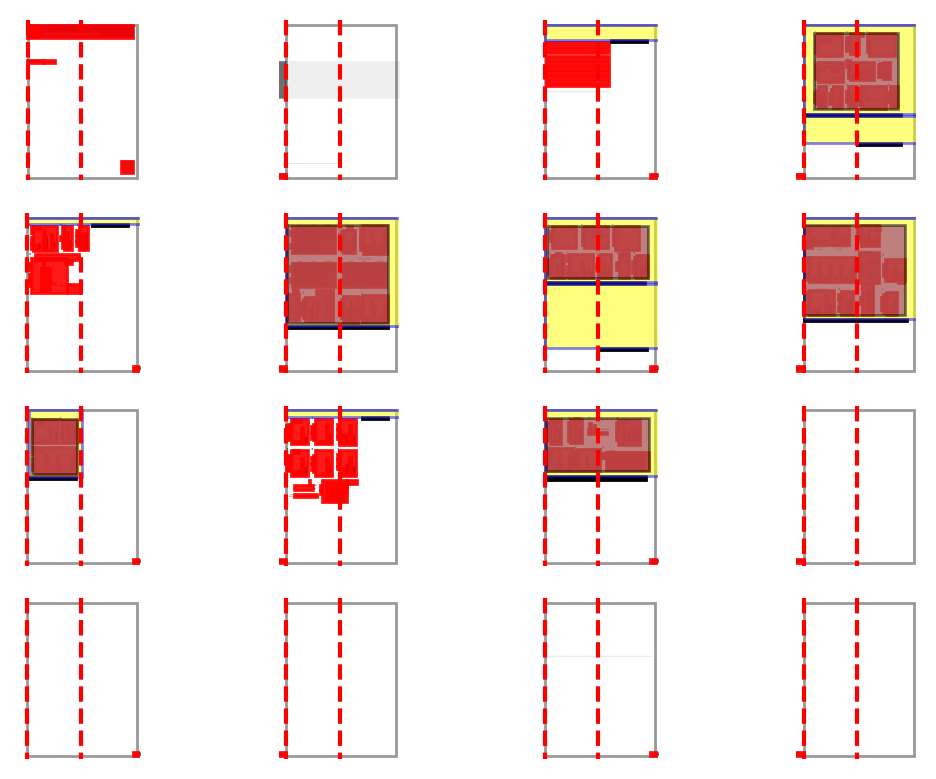

In [37]:
layout, row_width, row_height, cols_layout = calculate_document_layout(pages)
num_cols_in_doc = len(cols_layout)

number_cols = 4
number_rows = int(len(pages) / number_cols) 

_, ax = plt.subplots(number_rows, number_cols, dpi=200)

for idx, page in enumerate(pages):    
  page_name = page.img_name
  print(page_name)
  png_path = (Path(xpdf_folder_path) / page_name).resolve()

  col = idx % number_cols
  row = int(idx / number_cols)  

  page_image = Image.open(png_path)
  page_image = page_image.resize((page.width, page.height))
  draw_content_region(ax[row][col], content_region)  
  # draw_text_regions(ax[row][col], page)

  # probably don't filter by more height here yet, as some labels connect 
  # the figures
  candidates, fig_containers, table_containers = get_potential_figure_bboxes(xpdf_folder_path, page, layout, row_height)  
  draw_figure_candidates(ax[row][col], candidates)
  draw_columns(ax[row][col], cols_layout, page.height)

  caption_bboxes = [x.to_bbox() for x in fig_containers]
  draw_bboxes(ax[row][col], caption_bboxes, 'black', 'black', 1.0)  
  regions = estimate_caption_regions(fig_containers, num_cols_in_doc, page.width, page.height, row_width, row_height, cols_layout, layout)
  
  out_figures = label_subfig(regions, candidates)

  region_bboxes = [x[1] for x in regions]
  # print(region_bboxes)
  draw_bboxes(ax[row][col], region_bboxes, 'blue', 'yellow', 0.5)

  draw_bboxes(ax[row][col], out_figures, 'black', 'purple', 0.5)

  ax[row][col].imshow(page_image)
  ax[row][col].axis('off')




In [13]:
base_folder_path = xpdf_folder_path
page = pages[2]

png_path = str((Path(base_folder_path) / page.img_name).resolve())
page_image = cv2.imread(png_path)
page_image_gray = cv2.cvtColor(page_image, cv2.COLOR_BGR2GRAY)
scaling = calc_img_scale(page_image, page.width, page.height)

_, thresh = cv2.threshold(page_image_gray, 240, 255, cv2.THRESH_BINARY_INV)
kernel = np.ones((5, 5), np.uint8)
dilation = cv2.dilate(thresh, kernel, iterations=1)
contours, _ = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
canvas_with_contours = np.zeros(thresh.shape, dtype=np.uint8)

potential_fig_bboxes = []
for cnt in contours:
  cnt_bbox = cv2.boundingRect(cnt)
  scaled_cnt_bbox = [int(float(x) / scaling) for x in cnt_bbox]
  overlap_w_captions = 0
  overlap_w_layout = overlap_ratio_based(layout, scaled_cnt_bbox)
  print(overlap_w_layout)
  if overlap_w_layout < 0.2:
    cv2.drawContours(canvas_with_contours, [cnt], 0, 255, -1)

cv2.namedWindow("window", cv2.WINDOW_NORMAL)
imS = cv2.resize(canvas_with_contours, (page.width, page.height))  
cv2.imshow('window', imS)
cv2.waitKey(0)
cv2.destroyAllWindows()

0.0011541115222981873
0.0015404879884588847
0.009980555729787368
0.009980555729787368
0.009980555729787368
0.009980555729787368
0.009212820673649877
0.009212820673649877
0.009212820673649877
0.009212820673649877
0.009980555729787368
0.009980555729787368
0.0015404879884588847


QObject::moveToThread: Current thread (0x55d6ea57b290) is not the object's thread (0x55d6ebc71dc0).
Cannot move to target thread (0x55d6ea57b290)

QObject::moveToThread: Current thread (0x55d6ea57b290) is not the object's thread (0x55d6ebc71dc0).
Cannot move to target thread (0x55d6ea57b290)

QObject::moveToThread: Current thread (0x55d6ea57b290) is not the object's thread (0x55d6ebc71dc0).
Cannot move to target thread (0x55d6ea57b290)

QObject::moveToThread: Current thread (0x55d6ea57b290) is not the object's thread (0x55d6ebc71dc0).
Cannot move to target thread (0x55d6ea57b290)

QObject::moveToThread: Current thread (0x55d6ea57b290) is not the object's thread (0x55d6ebc71dc0).
Cannot move to target thread (0x55d6ea57b290)

QObject::moveToThread: Current thread (0x55d6ea57b290) is not the object's thread (0x55d6ebc71dc0).
Cannot move to target thread (0x55d6ea57b290)

QObject::moveToThread: Current thread (0x55d6ea57b290) is not the object's thread (0x55d6ebc71dc0).
Cannot move to tar